In [45]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from rdkit import Chem

from hotbit import Hotbit

import os
import cclib

import matplotlib.pyplot as plt
%matplotlib inline

import subprocess
import shlex

from autotst.job import Job as AutoTST_Job
from autotst.species import Conformer, Species
from autotst.calculators.gaussian import Gaussian as AutoTST_Gaussian
from autotst.reaction import Reaction

from rmgpy.molecule import Molecule as RMG_Molecule


In [46]:
def get_opt_energies(scan_log):
    """
    Sets data attributes using cclib and Arkane

    scan_log :: name of scan log
    path     :: path to scan log
    """
    parser = cclib.io.ccread(scan_log)

    opt_indices = [i for i, status in enumerate(parser.optstatus) if status==2]
    opt_SCFEnergies = [parser.scfenergies[index] for index in opt_indices]

    return [opt_SCFEnergies, parser]

def exists_and_complete(path):
    exists_and_complete = False
    auto_g = AutoTST_Gaussian()
    
    if os.path.isfile(path):
        if False not in auto_g.verify_output_file(path):
            exists_and_complete = True
    
    return exists_and_complete


def scan_progress(steps, step_size, Conf_list, SMILES_list=None, Rxn_list=None, base_path=None):
    auto_job = AutoTST_Job()
    assert (SMILES_list is not None) or (Rxn_list is not None) or (len(Conf_list)!=0)

    if (Rxn_list is not None):
        for rxn in Rxn_list:
            for species in rxn.reactants:
                for reac_list in species.conformers.values():
                    Conf_list += reac_list

            for species in rxn.products:
                for prod_list in species.conformers.values():
                    Conf_list += prod_list


    Conf_list += [Conformer(SMILES) for SMILES in SMILES_list]

    for conf in Conf_list:
        SMILES = conf.smiles
        
        augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
            Chem.MolFromSmiles(SMILES)))
                
        conf.view()
        path = '{}/{}/From_Workflow'.format(base_path, SMILES)
        os.chdir(path)
        print os.getcwd()
        
        for torsion in conf.torsions:
            print
            attempt = 1
            while attempt < 5:
                c_attempt = attempt
                attempt += 1

                [i, j, k, l] = torsion.atom_indices 

                output_log = augInChIKey + '_{0}by{1}_tor{2}{3}_a{4}.log'.format(steps, step_size, j, k, c_attempt)

                if not exists_and_complete(output_log):
                    print 'DNFind: ', output_log
                    continue
                else:
                    print '\nFound: ', output_log

                print SMILES
                print torsion
                print 'Steps:     ', steps
                print 'Step Size: ', step_size
                print 'Attempt:   ', c_attempt
                print


                
                opt_SCFenergies, parser = get_opt_energies(output_log)
                thetas = [i*step_size for i in range(steps+1)]
                print len(thetas), len(opt_SCFenergies)
                
                try:
                    assert len(thetas) == len(opt_SCFenergies)
                    plt.scatter(thetas, opt_SCFenergies)
                    plt.show()

                    print 'Continuous:  ', auto_job.check_rotor_continuous(steps, step_size, parser=parser)
                    print '\nGood Slope:  ', auto_job.check_rotor_slope(steps, step_size, parser=parser)
                    print '\nLowest Conf: ', auto_job.check_rotor_lowest_conf(parser=parser)[0]
                    print '=========================================================\n\n'
                except:
                    print 'CANNOT Load Scan\n'

                    print '=========================================================\n\n'
        
        print '===================================================================\n\n'

    return


def updated_conf_from_scan(conf, steps, step_size, attempt):
    
    augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
            Chem.MolFromSmiles(conf.smiles)))
        
    multiplicity = conf.rmg_molecule.multiplicity
    
    min_atomnos = None
    min_atomcoords = None
    min_energy = None
    
    desp_atomnos = None
    desp_atomcoords = None
    desp_energy = None
    
    using_lowest = True

    for torsion in conf.torsions:
        (i, j, k, l) = torsion.atom_indices

        output_log = '{0}_{1}by{2}_tor{3}{4}_a{5}.log'.format(augInChIKey, steps, step_size, j, k, attempt)
        assert exists_and_complete(output_log), 'Run currently in progress or DNF. Maybe rerun to completion or delete'

        parser = cclib.io.ccread(output_log)
        
        scan_info = auto_job.check_rotor_lowest_conf(steps, step_size, parser=parser)
        [lowest_conf, energy, atomnos, atomcoords] = scan_info
        
        continuous = auto_job.check_rotor_continuous(steps, step_size, parser=parser)
        good_slope = auto_job.check_rotor_slope(steps, step_size, parser=parser)
        
        if not lowest_conf:
            using_lowest = False
            if (energy < min_energy) or (min_energy is None):
                min_energy = energy
                min_atomnos = atomnos
                min_atomcoords = atomcoords
        
        elif good_slope and not continuous:
            last_geo = energies_of_interest(parser=parser)
            if (last_geo[1] < desp_energy) or (desp_energy is None):
                desp_atomnos = parser.atomnos
                desp_atomcoords = last_geo[0]
                desp_energy = last_geo[1]

    new_coords = None
    new_energy = None
    new_atomnos = None

    if not using_lowest:
        new_coords = min_atomcoords
        new_energy = min_energy
        new_atomnos = min_atomnos
    else:
        new_coords = desp_atomcoords
        new_energy = desp_energy
        new_atomnos = desp_atomnos
    
    for atom, atomno in zip(conf.rmg_molecule.atoms, new_atomnos):
        assert atom.number == atomno
        
    conf.ase_molecule.set_positions(newpositions=np.array(new_atomcoords))
    conf.update_coords_from(mol_type='ase')
    
    return conf



def hotbit_lowest_conf(SMILES):
    SMILES_list = [SMILES]
    spec = Species(SMILES_list)
    spec.generate_conformers(calculator=Hotbit())

    lowest_conf = None
    lowest_energy = None
    for smiles, confs in spec.conformers.items():
        for conf in confs:
            conf.ase_molecule.set_calculator(Hotbit())
            conf.energy = conf.ase_molecule.get_potential_energy()

            if (conf.energy < lowest_energy) or (lowest_energy is None):
                lowest_energy = conf.energy
                lowest_conf = conf

    return lowest_conf




def rote_Rotor_Input(conformer, 
                     torsion, 
                     file_name, 
                     path=None, 
                     method='m062x', 
                     basis='6-311+g(2df,2p)', 
                     job='Opt=(CalcFC,ModRedun)', 
                     steps=72, 
                     stepsize_deg=10.0):
    """
    Write Gaussian input file for torsion scan

    conformer :: Conformer Object
    torsion   :: Torsion Object
    file_name :: desired file name to be written to
    
    path     :: path of file to write
    method   :: Gaussian method
    basis    :: Gaussian basis
    job      :: Gaussian job key word

    steps        :: Number of steps in scan
    stepsize_deg :: change in DEGREES between steps
    """
    
    if path is None:
        path = os.getcwd()

    assert isinstance(stepsize_deg, float)
    (i, j, k, l) = (-1, -1, -1, -1)
    (i, j, k, l) = torsion.atom_indices
    mol = conformer.rmg_molecule
    mol.updateMultiplicity()

    output = '%nprocshared=20\n'
    output += '%mem=5GB\n'
    output += '#p {0}/{1} {2}\n'.format(method, basis, job)
    output += '\nGaussian Input Prepared from Scan Object\n'
    output += '\n0 {}\n'.format(mol.multiplicity)

    for i, atom in enumerate(mol.atoms):
        output += "{}     {}     {}     {}\n".format(atom.element, atom.coords[0], atom.coords[1], atom.coords[2])

    output += '\n'

    # For atom IDs, need to be careful to adjust mol's IDs by +1 so that they start at 1 instead of zero
    for bond in mol.getAllEdges():
        output += 'B {0} {1}\n'.format(bond.atom1.sortingLabel+1, bond.atom2.sortingLabel+1)

        
    assert (i!=j) and (j!=k) and (k!=l)
    
    output = output + 'D {0} {1} {2} {3} S {4} {5}'.format(i+1,
                                                           j+1,
                                                           k+1,
                                                           l+1,
                                                           steps,
                                                           stepsize_deg)
    output += '\n\n\n'

    with open(os.path.join(path, file_name), 'w') as F:
        F.write(output)
        F.close

    return





def improve_scans(steps, step_size, Conf_list, SMILES_list=None, Rxn_List=None, base_path=None):
    assert (SMILES_list is not None) or (Rxn_list is not None) or (len(Conf_list)!=0)

    if (Rxn_list is not None):
        for rxn in Rxn_list:
            for species in rxn.reactants:
                for reac_list in species.conformers.values():
                    Conf_list += reac_list

            for species in rxn.products:
                for prod_list in species.conformers.values():
                    Conf_list += prod_list


    Conf_list += [Conformer(SMILES) for SMILES in SMILES_list]

    
    for conf in Conf_list:
        SMILES = conf.smiles
        path = '{}/{}/From_Workflow'.format(base_path, SMILES)

        os.chdir(path)

        augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
                    Chem.MolFromSmiles(SMILES)))
                
        
        (i, j, k, l) = conf.torsions[0].atom_indices


        tor_base = '{0}_{1}by{2}_tor{3}{4}'.format(augInChIKey, steps, step_size, j, k)

        prev_attempt = 10
        file_name = tor_base + '_a{}.log'.format(prev_attempt)

        while not os.path.isfile(file_name):
            prev_attempt -= 1
            assert prev_attempt != 0
            file_name = tor_base + '_a{}.log'.format(prev_attempt)

        print SMILES
        print '  Previous Attempt: ', prev_attempt

        current_attempt = prev_attempt + 1

        all_verified, up_conf = updated_conf_from_scan(conf, steps, step_size, prev_attempt)

        if all_verified:
            print '  New Lowest Conformer Not Found'
        else:
            print '  Updated Conformer Found'

            augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
                Chem.MolFromSmiles(conf.smiles)))


            for torsion in up_conf.get_torsions():

            
                (i, j, k, l) = torsion.atom_indices

                assert exists_and_complete('{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt-1)), '{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt-1)
                assert not os.path.isfile('{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt)), '{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt)
                input_com = '{}_{}by{}_tor{}{}_a{}.com'.format(augInChIKey, steps, step_size, j, k, current_attempt)
                rote_Rotor_Input(up_conf, torsion, input_com, path=path)
                new_tor_base = input_com.strip('.com')
                print new_tor_base
                #subprocess.call(shlex.split('sbatch rotors_run_template.sh {0}'.format(new_tor_base)))

    return


def improve_scans(steps, step_size, Conf_list, SMILES_list=None, Rxn_List=None, input_base_path=None, output_base_path=None):
    assert (SMILES_list is not None) or (Rxn_list is not None) or (len(Conf_list)!=0)

    
    if output_base_path is None:
        output_base_path = os.getcwd()
    
    
    if (Rxn_list is not None):
        for rxn in Rxn_list:
            for species in rxn.reactants:
                for reac_list in species.conformers.values():
                    Conf_list += reac_list

            for species in rxn.products:
                for prod_list in species.conformers.values():
                    Conf_list += prod_list


    Conf_list += [Conformer(SMILES) for SMILES in SMILES_list]

    
    for conf in Conf_list:
        SMILES = conf.smiles
        path = '{}/{}/From_Workflow'.format(base_path, SMILES)

        os.chdir(path)

        augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
                    Chem.MolFromSmiles(SMILES)))
                
        
        (i, j, k, l) = conf.torsions[0].atom_indices


        tor_base = '{0}_{1}by{2}_tor{3}{4}'.format(augInChIKey, steps, step_size, j, k)

        prev_attempt = 10
        file_name = tor_base + '_a{}.log'.format(prev_attempt)

        while not os.path.isfile(file_name):
            prev_attempt -= 1
            assert prev_attempt != 0
            file_name = tor_base + '_a{}.log'.format(prev_attempt)

        print SMILES
        print '  Previous Attempt: ', prev_attempt

        current_attempt = prev_attempt + 1

        all_verified, up_conf = updated_conf_from_scan(conf, steps, step_size, prev_attempt)

        if all_verified:
            print '  New Lowest Conformer Not Found'
        else:
            print '  Updated Conformer Found'

            augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
                Chem.MolFromSmiles(conf.smiles)))


            for torsion in up_conf.get_torsions():

            
                (i, j, k, l) = torsion.atom_indices

                assert exists_and_complete('{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt-1)), '{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt-1)
                assert not os.path.isfile('{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt)), '{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt)
                input_com = '{}_{}by{}_tor{}{}_a{}.com'.format(augInChIKey, steps, step_size, j, k, current_attempt)
                rote_Rotor_Input(up_conf, torsion, input_com, path=path)
                new_tor_base = input_com.strip('.com')
                print new_tor_base
                #subprocess.call(shlex.split('sbatch rotors_run_template.sh {0}'.format(new_tor_base)))

    return

In [47]:


steps = 72
step_size = 10.0

Conf_list = []

Rxn_list = None

Master_SMILES_list = [
    'CCCCO',
    'CCCC[O]',
    'CCC[CH]O',
    'CC[CH]CO',
    'C[CH]CCO',
    '[CH2]CCCO',
    'CCOC',
    'C[CH]OC',
    'CCO[CH2]',
    '[CH2]COC',
    'COC(C)C',
    'CO[C](C)C',
    '[CH2]OC(C)C',
    '[CH2]C(C)OC',
    'CCC(=O)OC',
    'C[CH]C(=O)OC',
    '[CH2]CC(=O)OC',
    '[CH2]OC(=O)CC'
]


In [5]:
auto_job = AutoTST_Job()

SMILES_list = ['ONCC(=O)O']
Conf_list = []
Rxn_list = None


assert (SMILES_list is not None) or (Rxn_list is not None) or (len(Conf_list)!=0)

if (Rxn_list is not None):
    for rxn in Rxn_list:
        for species in rxn.reactants:
            for reac_list in species.conformers.values():
                Conf_list += reac_list

        for species in rxn.products:
            for prod_list in species.conformers.values():
                Conf_list += prod_list


Conf_list += [Conformer(SMILES) for SMILES in SMILES_list]


for conf in Conf_list:
    conf = Conformer(SMILES)
    path = '/home/underkoffler.c/Code/Hindered_Rotors/{}/From_Workflow'.format(SMILES)

    os.chdir(path)

    augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
        Chem.MolFromSmiles(SMILES)))
                
    (i, j, k, l) = conf.torsions[0].atom_indices

    steps = 72
    step_size = 10.0
    tor_base = '{0}_{1}by{2}_tor{3}{4}'.format(augInChIKey, steps, step_size, j, k)

    prev_attempt = 10
    file_name = tor_base + '_a{}.log'.format(prev_attempt)

    while not os.path.isfile(file_name):
        prev_attempt -= 1
        assert prev_attempt != 0
        file_name = tor_base + '_a{}.log'.format(prev_attempt)
    print SMILES
    print '  Previous Attempt: ', prev_attempt
    print

ONCC(=O)O
  Previous Attempt:  4



In [18]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = ['ONCC(=O)O']
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['ONCC(=O)O']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/ONCC(=O)O/From_Workflow

ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor03_a1.log
ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor03_a2.log
ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor03_a3.log
ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor03_a4.log

ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor15_a1.log
ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor15_a2.log
ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor15_a3.log
ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor15_a4.log

ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor34_a1.log
ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor34_a2.log
ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor34_a3.log
ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor34_a4.log

ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor45_a1.log
ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor45_a2.log
ONCC(=O)O NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor45_a3.log
ONCC(=O)O NPWGWQRXH

['CCCCO']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/CCCCO/From_Workflow


Found:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor03_a1.log
CCCCO
<Torsion "(14, 0, 3, 10)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


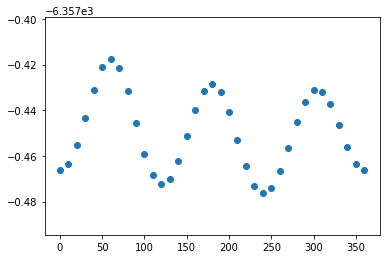

Continuous:   True

Good Slope:   True

Lowest Conf:  False


DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor03_a2.log
DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor03_a3.log
DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor03_a4.log


Found:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor12_a1.log
CCCCO
<Torsion "(8, 1, 2, 6)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


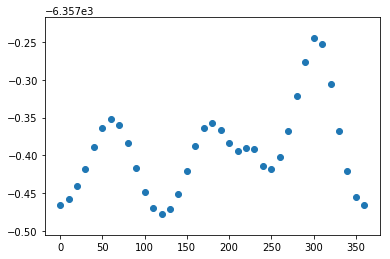

Continuous:   True

Good Slope:   True

Lowest Conf:  False


DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor12_a2.log
DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor12_a3.log
DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor12_a4.log


Found:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor13_a1.log
CCCCO
<Torsion "(8, 1, 3, 10)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


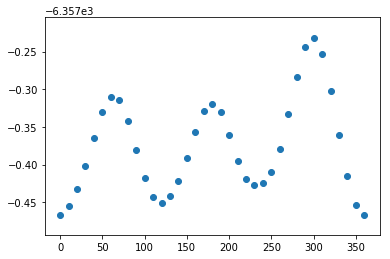

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor13_a2.log
DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor13_a3.log
DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor13_a4.log


Found:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor24_a1.log
CCCCO
<Torsion "(6, 2, 4, 12)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


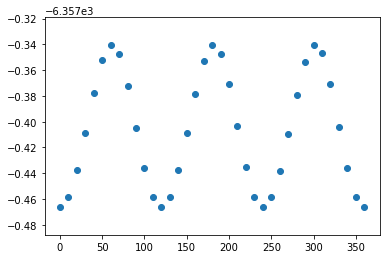

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor24_a2.log
DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor24_a3.log
DNFind:  LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor24_a4.log




In [49]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[0]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CCCC[O]']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/CCCC[O]/From_Workflow


Found:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor12_a1.log
CCCC[O]
<Torsion "(5, 1, 2, 8)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


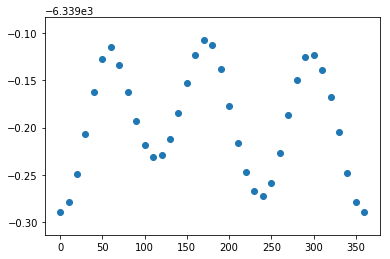

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor12_a2.log
DNFind:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor12_a3.log
DNFind:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor12_a4.log


Found:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor13_a1.log
CCCC[O]
<Torsion "(5, 1, 3, 11)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


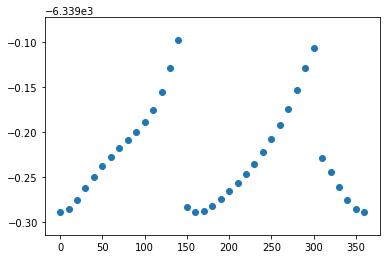

Continuous:   True

Good Slope:   False

Lowest Conf:  True


DNFind:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor13_a2.log
DNFind:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor13_a3.log
DNFind:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor13_a4.log


Found:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor24_a1.log
CCCC[O]
<Torsion "(8, 2, 4, 12)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 36
CANNOT Load Scan



DNFind:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor24_a2.log
DNFind:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor24_a3.log
DNFind:  QOOQLKSEGVNYLA-UHFFFAOYSA-N_36by10.0_tor24_a4.log




In [48]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[1]]
print SMILES_list
SMILES = SMILES_list[0]

conf = Conformer(SMILES)

augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
            Chem.MolFromSmiles(SMILES)))
    

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

In [9]:
conf = Conformer('CCCC[O]')
from hotbit import Hotbit


from autotst.calculators.gaussian import read_gaussian_out

def update_Conformer(conformer, file_name, path=None):
    """
    Updates conformer geometry from Gaussian geometry optimization output. If no filename specified tries by naming convention within path

    ACHTUNG!!! No Checks for whether conformer in file matches given conformer

    filename :: Geometry optimization log from Gaussian
    path :: path of file, default to cwd
    """

    if path is None:
        path = os.getcwd()

    os.chdir(path)
    conformer.ase_molecule = read_gaussian_out(file_name)
    
    conformer.update_coords()
    
    return conformer

print os.getcwd()
path = '/home/underkoffler.c/Code/Hindered_Rotors/CCCC[O]/From_Workflow'
os.chdir(path)

geo_name = 'QOOQLKSEGVNYLA-UHFFFAOYSA-N_GeoFreq_a1.log'
#conf.ase_molecule.set_calculator(Hotbit())
#conf.energy = conf.ase_molecule.get_potential_energy()






print
print conf.energy
for atom in conf.rmg_molecule.atoms:
    print atom.sortingLabel, atom.number, atom.coords
print
for torsion in conf.torsions:
    (i, j, k, l) =  torsion.atom_indices
    print torsion.atom_indices
    print i, j, k, l
    print





conf = update_Conformer(conf, geo_name)

print conf.energy

for atom in conf.rmg_molecule.atoms:
    print atom.sortingLabel, atom.number, atom.coords
print
for torsion in conf.torsions:
    (i, j, k, l) =  torsion.atom_indices
    print torsion.atom_indices
    print i, j, k, l
    print
    
print conf.rmg_molecule.toAugmentedInChIKey()

/home/underkoffler.c/Code/Hindered_Rotors/CCCC[O]/From_Workflow

None
0 8 [-2.6451 -1.3296  0.3454]
1 6 [ 0.4185  0.596  -0.0268]
2 6 [-0.3828 -0.6798 -0.2119]
3 6 [ 1.9001  0.3489 -0.0282]
4 6 [-1.8375 -0.2836 -0.0538]
5 1 [ 0.0785  1.077   0.9218]
6 1 [ 0.0808  1.2769 -0.8329]
7 1 [-0.1258 -1.4519  0.5411]
8 1 [-0.1704 -1.124  -1.199 ]
9 1 [ 2.4139  1.3025 -0.1975]
10 1 [ 2.1561 -0.3635 -0.837 ]
11 1 [ 2.1852 -0.0773  0.9552]
12 1 [-1.9046  0.4973  0.7433]
13 1 [-2.167   0.2111 -0.9855]

(2, 1, 3, 11)
2 1 3 11

(3, 1, 2, 7)
3 1 2 7

(7, 2, 4, 12)
7 2 4 12

None
0 8 [-2.66114943 -1.19733745  1.08140661]
1 6 [ 0.92456938 -0.65826609  0.05808759]
2 6 [-0.53351981 -1.08638499 -0.08984235]
3 6 [ 1.09790023  0.84722559  0.23899323]
4 6 [-1.36363992 -0.77981815  1.15209967]
5 1 [ 1.47549804 -0.98206149 -0.82593308]
6 1 [ 1.37192005 -1.18379268  0.90603551]
7 1 [-0.58929705 -2.16034229 -0.27490709]
8 1 [-0.99135557 -0.58949161 -0.9478474 ]
9 1 [ 2.15107809  1.12454215  0.24152543]
10 1 [ 0.6

In [61]:
from autotst.species import Conformer
import os
from ase.io.gaussian import read_gaussian_out
from hotbit import Hotbit
import pickle

from rdkit import Chem
from autotst.job import Job as AutoTST_Job

import numpy as np


def ASE_updated_conf_from_scans(conf, steps, step_size, attempt):
    auto_job = AutoTST_Job()
    
    augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
            Chem.MolFromSmiles(conf.smiles)))
        
    multiplicity = conf.rmg_molecule.multiplicity
    
    min_atomnos = None
    min_atomcoords = None
    min_energy = None
    all_verified = True

    for torsion in conf.torsions:
        (i, j, k, l) = torsion.atom_indices

        output_log = '{0}_{1}by{2}_tor{3}{4}_a{5}.log'.format(augInChIKey, steps, step_size, j, k, attempt)
        
        scan_info = auto_job.check_rotor_lowest_conf(file_name=output_log, tol=0.0)
        print output_log
        [verified, energy, atomnos, atomcoords] = scan_info
        
        if (min_energy is None) or (energy<min_energy):
            min_energy = energy
            min_atomnos = atomnos
            min_atomcoords = atomcoords

    
    assert min_atomnos is not None
    assert min_atomcoords is not None
    
    
    for ase_atomno, atomno in zip(conf.ase_molecule.get_atomic_numbers(), min_atomnos):
        assert ase_atomno == atomno
    
    
    conf.ase_molecule.set_positions(newpositions=np.array(min_atomcoords))
    conf.update_coords_from(mol_type='ase')
    
    return [conf, min_energy]


SMILES_list = ['ONCC(=O)O']
steps = 72
step_size = 10.0
base_path = '/home/underkoffler.c/Code/Hindered_Rotors'


for SMILES in SMILES_list:
    conf_dict = {}
    augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
                Chem.MolFromSmiles(conf.smiles)))


    general_conf = Conformer(SMILES)
    conf_dict['gen_conf'] = general_conf

    path = '{}/{}/From_Workflow'.format(base_path, SMILES)
    os.chdir(path)

    
    
    
    
    og_geo_conf = general_conf
    og_geo_log = augInChIKey + '_GeoFreq.log'
    if os.path.isfile(og_geo_log):
        og_geo_conf.ase_molecule = read_gaussian_out(og_geo_log)
        og_geo_conf.update_coords()
        conf_dict['og_geo_log'] = og_geo_conf
        print og_geo_log

    for attempt in range(1,10):
        
        geo_log = augInChIKey + '_GeoFreq_a{}.log'.format(attempt)
        
        if os.path.isfile(geo_log):
            geo_conf = general_conf
            geo_conf.ase_molecule = read_gaussian_out(geo_log)
            geo_conf.update_coords()
            geo_conf.ase_molecule
            conf_dict['geo_a{}'.format(attempt)] = geo_conf
            
        
        
        try:
            scan_conf = ASE_updated_conf_from_scans(general_conf, steps, step_size, attempt)[0]
            conf_dict['scans_a{}'.format(attempt)] = scan_conf
        except:
            pass

    lowest_conf = None
    
    for source, conformer in conf_dict.items():
        conformer.update_coords_from(mol_type='ase')
        conformer.ase_molecule = conformer.get_ase_mol()
        conformer.ase_molecule.set_calculator(Hotbit())
    
        conformer.energy = conformer.ase_molecule.get_potential_energy()

        if (lowest_conf is None) or (conformer.energy < lowest_conf.energy):
            lowest_conf = conformer

    #conf_dict['hotbit_gen'] = hotbit_lowest_conf(SMILES)


NPWGWQRXHVJJRD-UHFFFAOYSA-N_GeoFreq.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor03_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor15_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor34_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor45_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor03_a2.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor15_a2.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor34_a2.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor45_a2.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor03_a3.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor15_a3.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor34_a3.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor45_a3.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor03_a4.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor15_a4.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor34_a4.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor45_a4.log
Solved one time; Iterations: 6

Timing:
            label                    time     calls    %sub  %covered   %tot
-------------------------------------------

Hamiltonian ~91.201 % filled.
Solved one time; Iterations: 6

Timing:
            label                    time     calls    %sub  %covered   %tot
-------------------------------------------------------------------------------
Hotbit                               0.627         1 (100.0 %, 95.0 %) 100.0 % |000000000000000000000000000000|
../initialization                    0.424         1 ( 67.6 %        )  67.6 % |11111111111111111111|
../geometry                          0.003         1 (  0.5 %, 43.9 %)   0.5 % ||
../../operations                     0.000         1 (  0.9 %        )   0.0 % ||
../../displacements                  0.001         1 ( 42.9 %        )   0.2 % ||
../solve                             0.166         1 ( 26.5 %, 94.9 %)  26.5 % |11111111|
../../matrix construction            0.132         1 ( 79.6 %        )  21.1 % |222222|
../../gamma matrix                   0.002         1 (  1.5 %        )   0.4 % ||
../../h1                             0.006         7 

Hamiltonian ~91.201 % filled.
Solved one time; Iterations: 6

Timing:
            label                    time     calls    %sub  %covered   %tot
-------------------------------------------------------------------------------
Hotbit                               0.627         1 (100.0 %, 94.5 %) 100.0 % |000000000000000000000000000000|
../initialization                    0.422         1 ( 67.3 %        )  67.3 % |11111111111111111111|
../geometry                          0.003         1 (  0.5 %, 37.4 %)   0.5 % ||
../../operations                     0.000         1 (  1.0 %        )   0.0 % ||
../../displacements                  0.001         1 ( 36.4 %        )   0.2 % ||
../solve                             0.166         1 ( 26.5 %, 94.7 %)  26.5 % |11111111|
../../matrix construction            0.132         1 ( 79.7 %        )  21.1 % |222222|
../../gamma matrix                   0.002         1 (  1.2 %        )   0.3 % ||
../../h1                             0.006         7 

Hamiltonian ~91.201 % filled.


In [10]:

def geos_of_interest(parser=None, file_name=None):
    if parser is None:
        assert file_name is not None, "Need either parser or file_name"
        parser = cclib.io.ccread(file_name)

    min_energy = None
    min_coords = None

    atomnos = parser.atomnos

    opt_indices = [idx for idx, status in enumerate(parser.optstatus) if status==2]
    opt_SCFenergies = [parser.scfenergies[idx] for idx in opt_indices]

    init_atomcoords = parser.atomcoords[0]
    init_energy = parser.scfenergies[0]

    first_atomcoords = parser.atomcoords[opt_indices[0]]
    first_energy = parser.scfenergies[opt_indices[0]]

    last_atomcoords = parser.atomcoords[opt_indices[-1]]
    last_energy = parser.scfenergies[opt_indices[-1]]

    lowest_atomcoords = None
    lowest_energy = None
    for opt_idx in opt_indices:
        energy = parser.scfenergies[opt_idx]
        if (energy < lowest_energy) or (lowest_energy is None):
            lowest_energy = energy
            lowest_atomcoords = parser.atomcoords[opt_idx]
    
    geometries = {}
    geometries['scan_init'] = [init_atomcoords, init_energy]
    geometries['sacn_first'] = [first_atomcoords, first_energy]
    geometries['scan_lowest'] = [lowest_atomcoords, lowest_energy]
    geometries['scan_last'] = [last_atomcoords, last_energy]
    
    return geometries

In [81]:
"""for source, conf in conf_dict.items():
    with open('del_conf.pickle', 'wb') as f:
        positions = conf.ase_molecule.get_positions()
        atomnos = conf.ase_molecule.get_atomic_numbers()
        chem_symb = conf.ase_molecule.get_chemical_symbols()
        energy = conf.energy
        
        info = [
            positions,
            atomnos,
            chem_symb,
            energy
        ]
        
        pickle.dump(info, f)
    
    break"""
x=1

In [3]:
os.chdir('/home/underkoffler.c/Code/Hindered_Rotors/clean_run1')

In [3]:
import numpy as np
import cclib

from autotst.species import Conformer

from hotbit import Hotbit

from ase.calculators.gaussian import Gaussian as ASE_Gaussian


SMILES_list = ['ONCC(=O)O']
base_paths = [
    '/home/underkoffler.c/Code/Hindered_Rotors',
    '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1'
]







def GeoFreqCom_from_Conf(conf, file_name=None):
    
    gaus_job = ASE_Gaussian()
    
    if file_name is None:
        gaus_job.label = conf.rmg_molecule.toAugmentedInChIKey() + '_GeoFreq'
    else:
        gaus_job.label = file_name
        
    gaus_job.parameters['mem'] = '5GB'
    gaus_job.parameters['nprocshared'] = '20'
    gaus_job.parameters['method'] = 'm062x'
    gaus_job.parameters['basis'] = '6-311+g(2df,2p)'
    conf.rmg_molecule.updateMultiplicity()
    gaus_job.parameters['multiplicity'] = conf.rmg_molecule.multiplicity
    gaus_job.extra = 'opt=(calcfc,verytight,gdiis,maxcycles=900) freq iop(7/33=1,2/16=3)'

    
    del gaus_job.parameters['force']
    
    gaus_job.write_input(conf.ase_molecule)
    
    return


def generate_rotors_run_script(path=None):
    
    if path is None:
        path = os.getcwd()
    
    lst_template = ["#!/bin/bash",
                    "",
                    "#SBATCH --job-name=AutoScript",
                    "#SBATCH --output=$1.log",
                    "",
                    "## number of nodes",
                    "#SBATCH -N 1",
                    "#SBATCH --exclusive",
                    "#SBATCH --partition=general",
                    "#SBATCH --mem=120000",
                    "",
                    "## export GAUSS_SCRDIR=/scratch/$USER/gaussian_scratch",
                    "## make the directory if it doesn't exist already",
                    "## mkdir -p $GAUSS_SCRDIR",
                    "",
                    "## run gaussian, with the desired input file",
                    "g16 $1.com",
                    "",
                    ""]


    template ='\n'.join(lst_template)
    with open('{}/rotors_run_template.sh'.format(path), 'w') as f:
        f.write(template)
        
    return



def geos_of_interest(parser=None, file_name=None):
    if parser is None:
        assert file_name is not None, "Need either parser or file_name"
        parser = cclib.io.ccread(file_name)

    min_energy = None
    min_coords = None

    atomnos = parser.atomnos

    opt_indices = [idx for idx, status in enumerate(parser.optstatus) if status==2]
    opt_SCFenergies = [parser.scfenergies[idx] for idx in opt_indices]

    init_atomcoords = parser.atomcoords[0]
    init_energy = parser.scfenergies[0]

    first_atomcoords = parser.atomcoords[opt_indices[0]]
    first_energy = parser.scfenergies[opt_indices[0]]

    last_atomcoords = parser.atomcoords[opt_indices[-1]]
    last_energy = parser.scfenergies[opt_indices[-1]]

    lowest_atomcoords = None
    lowest_energy = None
    for opt_idx in opt_indices:
        energy = parser.scfenergies[opt_idx]
        if (energy < lowest_energy) or (lowest_energy is None):
            lowest_energy = energy
            lowest_atomcoords = parser.atomcoords[opt_idx]
    
    geometries = {}
    geometries['scan_init'] = [init_atomcoords, init_energy]
    geometries['sacn_first'] = [first_atomcoords, first_energy]
    geometries['scan_lowest'] = [lowest_atomcoords, lowest_energy]
    geometries['scan_last'] = [last_atomcoords, last_energy]
    
    return geometries



















for SMILES in SMILES_list:
    gen_conf = Conformer(SMILES)
    gen_conf.ase_molecule.set_calculator(Hotbit())
    gen_conf.energy = gen_conf.ase_molecule.get_potential_energy()

    conf_dict = {}
    conf_dict['default'] = gen_conf
    
    
    for base_path in base_paths:
        path = '{}/{}/From_Workflow'.format(base_path, SMILES)
        
        os.chdir(path)

        for log in os.listdir(path):
            if log.endswith('.log'):
                parser = None
                new_conf = Conformer(SMILES)
                
                try:
                    parser = cclib.io.ccread(log)
                    assert parser is not None
                except:
                    continue

                geos = geos_of_interest(parser=parser)

                atomcoords, scfenergy = geos['scan_lowest']

                new_conf.ase_molecule.set_positions(atomcoords)
                new_conf.update_coords_from(mol_type='ase')

                new_conf.ase_molecule.set_calculator(Hotbit())
                new_conf.energy = new_conf.ase_molecule.get_potential_energy()

                conf_dict[path+'/'+log] = new_conf

    already_hotbit_gened = False
    for key in conf_dict.keys():
        if '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' in key:
            already_hotbit_gened = True
    
    if not already_hotbit_gened:
        hotbit_conf = Conformer(SMILES)
        hotbit_conf.energy = -100
        #hotbit_conf = hotbit_lowest_conf(SMILES)
        #assert hotbit_conf.energy is not None

        conf_dict['hotbit_gen'] = hotbit_conf
    
    output = SMILES + '\n'
    output += 'Energy of conformer using hotbit: Log conformer came from\n\n'
    output += 'If log is scan, conformer chosen by lowest SCF energy\n\n'
    
    min_conf = None
    min_energy = None
    min_key = None
    for key, conf in conf_dict.items():
        output += '{}\t:\t{}\n'.format(conf.energy, key)
        
        if (min_energy is None) or (conf.energy < min_energy):
            min_conf = conf
            min_energy = conf.energy
            min_key = key
    
    
    output += '\nLOWEST FOUND:\n{}\t:\t{}\n'.format(min_energy, min_key)
    
    
    
    
                    
    base_output = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2'
    path_output = '{}/{}/From_Workflow'.format(base_output, SMILES)
    
    
    
    if not os.path.isdir(path_output):
        os.makedirs(path_output)
    os.chdir(path_output)
    
    generate_rotors_run_script(path=path_output)
    
    with open('Lowest_Conf_Search.txt', 'w') as f:
        f.write(output)
    
    augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
            Chem.MolFromSmiles(SMILES)))
    
    geo_Freq_Base = augInChIKey + '_GeoFreq_a1'
    
    GeoFreqCom_from_Conf(min_conf, file_name=geo_Freq_Base)
    #subprocess.call(shlex.split('sbatch rotors_run_template.sh {0}'.format(geo_Freq_Base)))
    
    
    











 _           _    _     _ _
| |__   ___ | |_ | |__ |_| |_
|  _ \ / _ \|  _||  _ \| |  _|
| | | | ( ) | |_ | ( ) | | |_
|_| |_|\___/ \__|\____/|_|\__|  ver. 0.1 (svn=Unversioned directory)
Distributed under GNU GPL; see /home/underkoffler.c/Code/hotbit/lib/python/LICENSE
Date: Sun Mar 10 23:51:15 2019
Nodename: c0066
Arch: x86_64
Dir: /home/underkoffler.c/Code/Hindered_Rotors
System: H5C2O3N
       Charge= 0.0
       Container Bravais: pbc:[0,0,0], cell:[0.00,0.00,0.00] Ang, 
   cosines(12,13,23):[nan,nan,nan]
Symmetry operations (if any):
       0: pbc= False , kappa-points=1, M=1
       1: pbc= False , kappa-points=1, M=1
       2: pbc= False , kappa-points=1, M=1
Electronic temperature: 0.02 eV
Mixer: Anderson with memory = 3 , mixing parameter = 0.2
11 atoms, 29 states, 36.0 electrons (18.0 filled states)
Initial n ranges:[0,0] [0,0] [0,0] 
Element O in /home/underkoffler.c/Code/hotbit/param/O.elm
    *no comment
Element N in /home/underkoffler.c/Code/hotbit/param/N.elm
    *n

/home/underkoffler.c/Code/hotbit/lib/python/hotbit/containers/bravais.py:28: RuntimeWarning: invalid value encountered in double_scalars
  a12 = np.dot(cell[0],cell[1])/(d[0]*d[1])
/home/underkoffler.c/Code/hotbit/lib/python/hotbit/containers/bravais.py:29: RuntimeWarning: invalid value encountered in double_scalars
  a13 = np.dot(cell[0],cell[2])/(d[0]*d[2])
/home/underkoffler.c/Code/hotbit/lib/python/hotbit/containers/bravais.py:30: RuntimeWarning: invalid value encountered in double_scalars
  a23 = np.dot(cell[1],cell[2])/(d[1]*d[2])


NameError: name 'os' is not defined

In [4]:
"""for key in geos:
    atomcoords, energy = geos[key]

    new_conf = Conformer(SMILES)    
    new_conf.ase_molecule.set_positions(atomcoords)
    new_conf.update_coords_from(mol_type='ase')

    new_conf.ase_molecule.set_calculator(Hotbit())
    new_conf.energy = new_conf.ase_molecule.get_potential_energy()

    conf_dict[key] = new_conf
"""
#sconf_dict['hotbit_gen'] = hotbit_lowest_conf(SMILES)
"""    
pickle_dict = {}
for key, conf in sconf_dict.items():
    SMILES = conf.smiles
    atomcoords = conf.ase_molecule.get_positions()
    energy = conf.energy
    pickle_dict[key] = [SMILES, atomcoords, energy]
"""    

x=1

['CCC[CH]O']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/CCC[CH]O/From_Workflow


Found:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor04_a1.log
CCC[CH]O
<Torsion "(13, 0, 4, 12)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


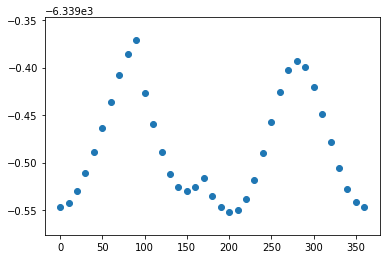

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor04_a2.log
DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor04_a3.log
DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor04_a4.log


Found:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor13_a1.log
CCC[CH]O
<Torsion "(2, 1, 3, 10)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


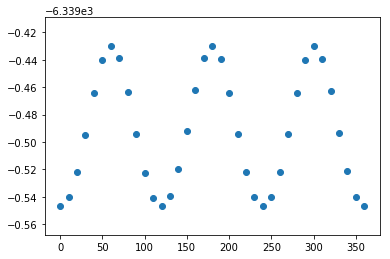

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor13_a2.log
DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor13_a3.log
DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor13_a4.log


Found:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor12_a1.log
CCC[CH]O
<Torsion "(6, 1, 2, 4)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


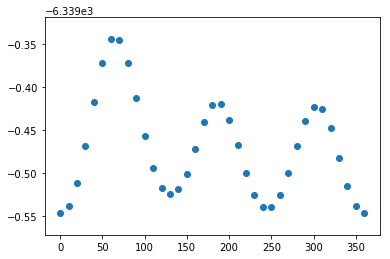

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor12_a2.log
DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor12_a3.log
DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor12_a4.log


Found:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor24_a1.log
CCC[CH]O
<Torsion "(8, 2, 4, 12)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


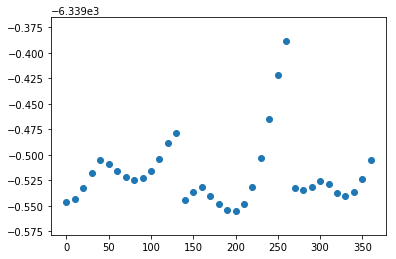

Continuous:   False

Good Slope:   False

Lowest Conf:  False


DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor24_a2.log
DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor24_a3.log
DNFind:  DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor24_a4.log




In [50]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[2]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CC[CH]CO']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/CC[CH]CO/From_Workflow


Found:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor02_a1.log
CC[CH]CO
<Torsion "(13, 0, 2, 4)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


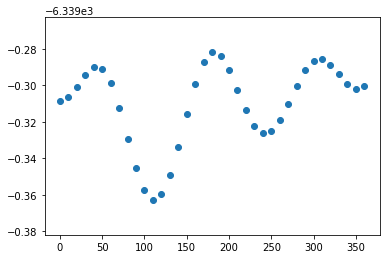

Continuous:   False

Good Slope:   True

Lowest Conf:  False


DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor02_a2.log
DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor02_a3.log
DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor02_a4.log


Found:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor13_a1.log
CC[CH]CO
<Torsion "(6, 1, 3, 8)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 36
CANNOT Load Scan



DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor13_a2.log
DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor13_a3.log
DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor13_a4.log


Found:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor14_a1.log
CC[CH]CO
<Torsion "(6, 1, 4, 12)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


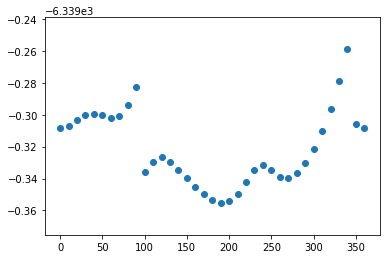

Continuous:   True

Good Slope:   False

Lowest Conf:  False


DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor14_a2.log
DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor14_a3.log
DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor14_a4.log


Found:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor24_a1.log
CC[CH]CO
<Torsion "(11, 2, 4, 12)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


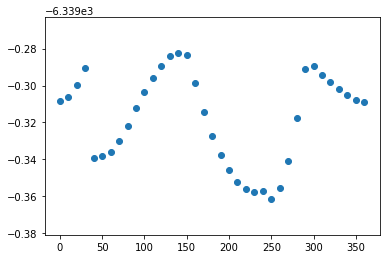

Continuous:   True

Good Slope:   False

Lowest Conf:  False


DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor24_a2.log
DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor24_a3.log
DNFind:  GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor24_a4.log




In [26]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[3]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['C[CH]CCO']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/C[CH]CCO/From_Workflow


Found:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor02_a1.log
C[CH]CCO
<Torsion "(13, 0, 2, 7)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


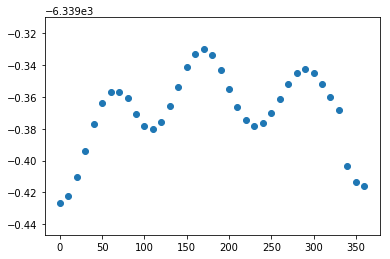

Continuous:   False

Good Slope:   False

Lowest Conf:  True


DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor02_a2.log
DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor02_a3.log
DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor02_a4.log


Found:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor14_a1.log
C[CH]CCO
<Torsion "(5, 1, 4, 12)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


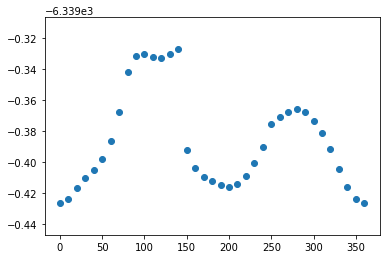

Continuous:   True

Good Slope:   False

Lowest Conf:  True


DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor14_a2.log
DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor14_a3.log
DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor14_a4.log


Found:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor12_a1.log
C[CH]CCO
<Torsion "(5, 1, 2, 7)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


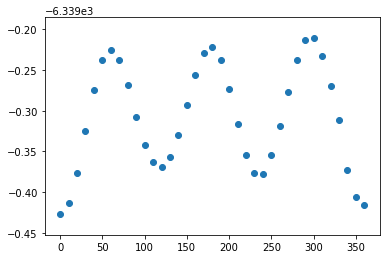

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor12_a2.log
DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor12_a3.log
DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor12_a4.log


Found:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor34_a1.log
C[CH]CCO
<Torsion "(9, 3, 4, 12)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


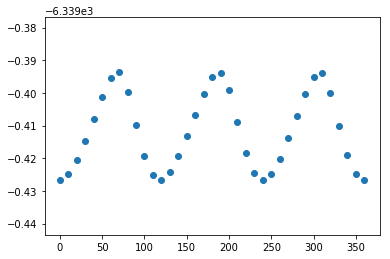

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor34_a2.log
DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor34_a3.log
DNFind:  DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor34_a4.log




In [27]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[4]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['[CH2]CCCO']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/[CH2]CCCO/From_Workflow


Found:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor03_a1.log
[CH2]CCCO
<Torsion "(13, 0, 3, 9)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 36
CANNOT Load Scan



DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor03_a2.log
DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor03_a3.log
DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor03_a4.log


Found:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor13_a1.log
[CH2]CCCO
<Torsion "(2, 1, 3, 9)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


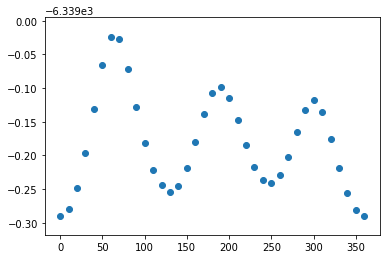

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor13_a2.log
DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor13_a3.log
DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor13_a4.log


Found:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor12_a1.log
[CH2]CCCO
<Torsion "(6, 1, 2, 8)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


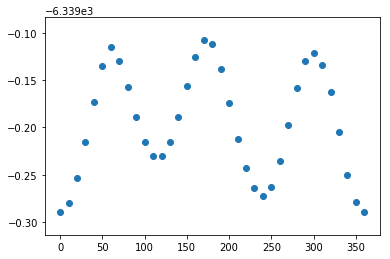

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor12_a2.log
DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor12_a3.log
DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor12_a4.log


Found:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor24_a1.log
[CH2]CCCO
<Torsion "(8, 2, 4, 12)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


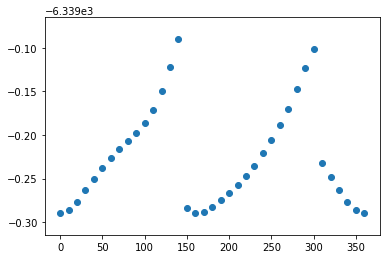

Continuous:   True

Good Slope:   False

Lowest Conf:  True


DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor24_a2.log
DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor24_a3.log
DNFind:  SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor24_a4.log




In [28]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[5]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

In [29]:
steps = 72
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[6]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CCOC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/CCOC/From_Workflow

DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor01_a1.log
DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor01_a2.log
DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor01_a3.log
DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor01_a4.log

DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor03_a1.log
DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor03_a2.log
DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor03_a3.log
DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor03_a4.log

DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor12_a1.log
DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor12_a2.log
DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor12_a3.log
DNFind:  XOBKSJJDNFUZPF-UHFFFAOYSA-N_72by10.0_tor12_a4.log




In [30]:
steps = 72
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[7]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['C[CH]OC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/C[CH]OC/From_Workflow

DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor03_a1.log
DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor03_a2.log
DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor03_a3.log
DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor03_a4.log

DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor02_a1.log
DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor02_a2.log
DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor02_a3.log
DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor02_a4.log

DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor13_a1.log
DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor13_a2.log
DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor13_a3.log
DNFind:  JQCSUVJDBHJKNG-UHFFFAOYSA-N_72by10.0_tor13_a4.log




In [31]:
steps = 72
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[8]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CCO[CH2]']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/CCO[CH2]/From_Workflow

DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor03_a1.log
DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor03_a2.log
DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor03_a3.log
DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor03_a4.log

DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor01_a1.log
DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor01_a2.log
DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor01_a3.log
DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor01_a4.log

DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor12_a1.log
DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor12_a2.log
DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor12_a3.log
DNFind:  TVFRQKHUZDMLDB-UHFFFAOYSA-N_72by10.0_tor12_a4.log




['[CH2]COC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/[CH2]COC/From_Workflow


Found:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor01_a1.log
[CH2]COC
<Torsion "(2, 0, 1, 3)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 36
CANNOT Load Scan



DNFind:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor01_a2.log
DNFind:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor01_a3.log
DNFind:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor01_a4.log


Found:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor02_a1.log
[CH2]COC
<Torsion "(1, 0, 2, 7)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


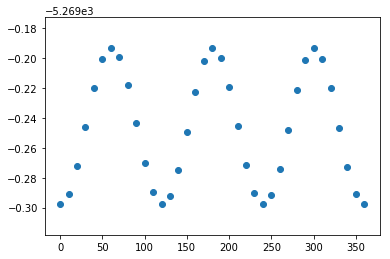

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor02_a2.log
DNFind:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor02_a3.log
DNFind:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor02_a4.log


Found:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor13_a1.log
[CH2]COC
<Torsion "(4, 1, 3, 9)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


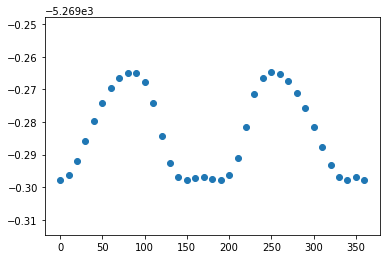

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor13_a2.log
DNFind:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor13_a3.log
DNFind:  ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor13_a4.log




In [32]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[9]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

In [33]:
steps = 72
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[10]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['COC(C)C']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/COC(C)C/From_Workflow

DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor01_a1.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor01_a2.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor01_a3.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor01_a4.log

DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor04_a1.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor04_a2.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor04_a3.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor04_a4.log

DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor12_a1.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor12_a2.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor12_a3.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor12_a4.log

DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor13_a1.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor13_a2.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N_72by10.0_tor13_a3.log
DNFind:  RMGHERXMTMUMMV-UHFFFAOYSA-N

In [34]:
steps = 72
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[11]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CO[C](C)C']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/CO[C](C)C/From_Workflow

DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor03_a1.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor03_a2.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor03_a3.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor03_a4.log

DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor04_a1.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor04_a2.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor04_a3.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor04_a4.log

DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor14_a1.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor14_a2.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor14_a3.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor14_a4.log

DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor24_a1.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor24_a2.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA-N_72by10.0_tor24_a3.log
DNFind:  VSQGJBCHGBRHMO-UHFFFAOYSA

['[CH2]OC(C)C']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/[CH2]OC(C)C/From_Workflow


Found:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor04_a1.log
[CH2]OC(C)C
<Torsion "(1, 0, 4, 13)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


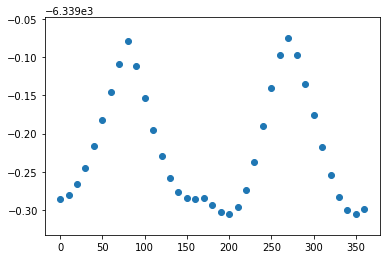

Continuous:   False

Good Slope:   True

Lowest Conf:  False


DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor04_a2.log
DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor04_a3.log
DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor04_a4.log


Found:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor01_a1.log
[CH2]OC(C)C
<Torsion "(4, 0, 1, 2)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


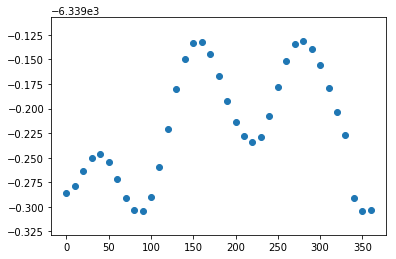

Continuous:   False

Good Slope:   False

Lowest Conf:  False


DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor01_a2.log
DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor01_a3.log
DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor01_a4.log


Found:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor13_a1.log
[CH2]OC(C)C
<Torsion "(2, 1, 3, 11)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


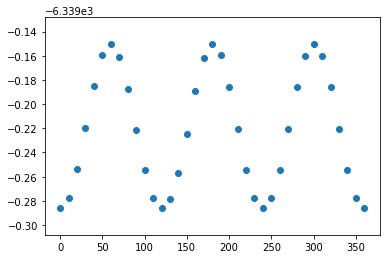

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor13_a2.log
DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor13_a3.log
DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor13_a4.log


Found:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor12_a1.log
[CH2]OC(C)C
<Torsion "(3, 1, 2, 6)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


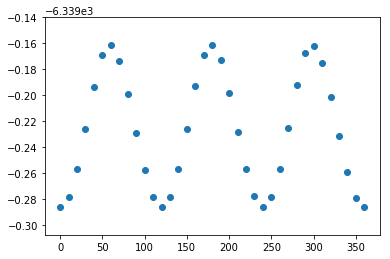

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor12_a2.log
DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor12_a3.log
DNFind:  BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor12_a4.log




In [35]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[12]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['[CH2]C(C)OC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/[CH2]C(C)OC/From_Workflow


Found:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor03_a1.log
[CH2]C(C)OC
<Torsion "(1, 0, 3, 9)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


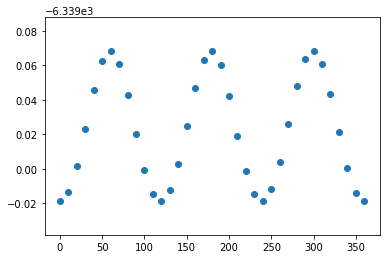

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor03_a2.log
DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor03_a3.log
DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor03_a4.log


Found:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor01_a1.log
[CH2]C(C)OC
<Torsion "(3, 0, 1, 2)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


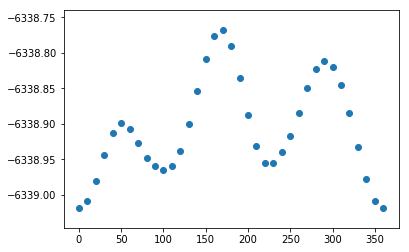

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor01_a2.log
DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor01_a3.log
DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor01_a4.log


Found:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor14_a1.log
[CH2]C(C)OC
<Torsion "(2, 1, 4, 12)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


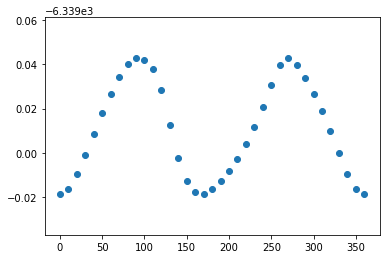

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor14_a2.log
DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor14_a3.log
DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor14_a4.log


Found:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor12_a1.log
[CH2]C(C)OC
<Torsion "(4, 1, 2, 6)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


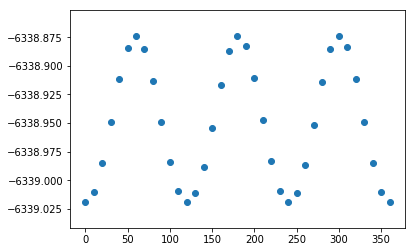

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor12_a2.log
DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor12_a3.log
DNFind:  FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor12_a4.log




In [36]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[13]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CCC(=O)OC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/CCC(=O)OC/From_Workflow


Found:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor05_a1.log
CCC(=O)OC
<Torsion "(4, 0, 5, 2)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


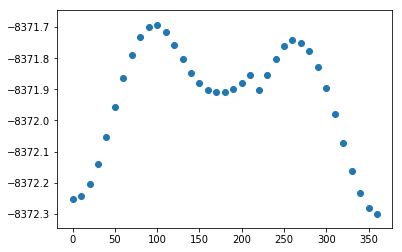

Continuous:   False

Good Slope:   True

Lowest Conf:  False


DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor05_a2.log
DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor05_a3.log
DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor05_a4.log


Found:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor04_a1.log
CCC(=O)OC
<Torsion "(5, 0, 4, 11)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


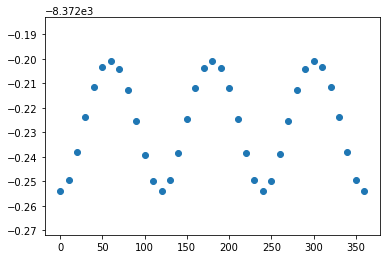

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor04_a2.log
DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor04_a3.log
DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor04_a4.log


Found:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor25_a1.log
CCC(=O)OC
<Torsion "(7, 2, 5, 1)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


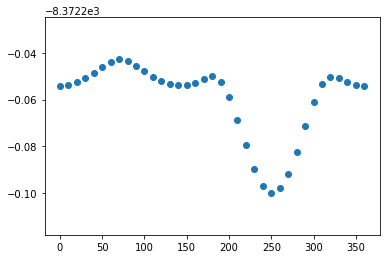

Continuous:   True

Good Slope:   True

Lowest Conf:  False


DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor25_a2.log
DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor25_a3.log
DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor25_a4.log


Found:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor23_a1.log
CCC(=O)OC
<Torsion "(7, 2, 3, 8)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


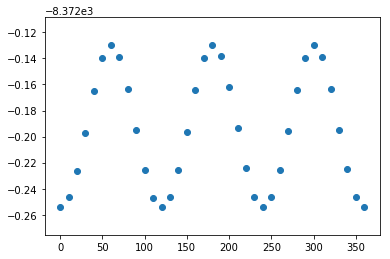

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor23_a2.log
DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor23_a3.log
DNFind:  RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor23_a4.log




In [37]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[14]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['C[CH]C(=O)OC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/C[CH]C(=O)OC/From_Workflow


Found:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor03_a1.log
C[CH]C(=O)OC
<Torsion "(5, 0, 3, 11)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


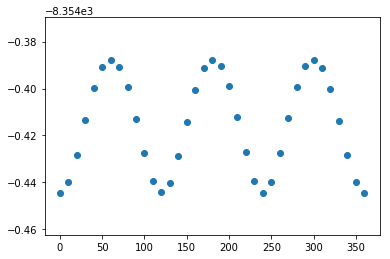

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor03_a2.log
DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor03_a3.log
DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor03_a4.log


Found:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor05_a1.log
C[CH]C(=O)OC
<Torsion "(3, 0, 5, 4)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


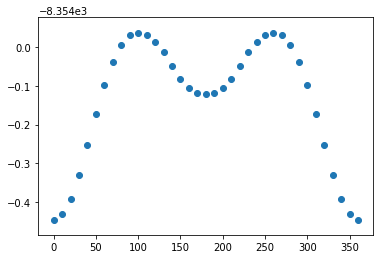

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor05_a2.log
DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor05_a3.log
DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor05_a4.log


Found:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor24_a1.log
C[CH]C(=O)OC
<Torsion "(8, 2, 4, 5)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


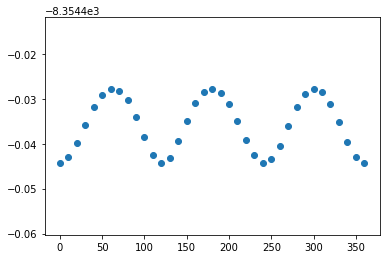

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor24_a2.log
DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor24_a3.log
DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor24_a4.log


Found:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor45_a1.log
C[CH]C(=O)OC
<Torsion "(12, 4, 5, 1)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


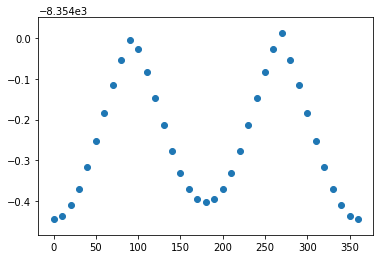

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor45_a2.log
DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor45_a3.log
DNFind:  DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor45_a4.log




In [38]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[15]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['[CH2]CC(=O)OC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/[CH2]CC(=O)OC/From_Workflow


Found:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor03_a1.log
[CH2]CC(=O)OC
<Torsion "(4, 0, 3, 9)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


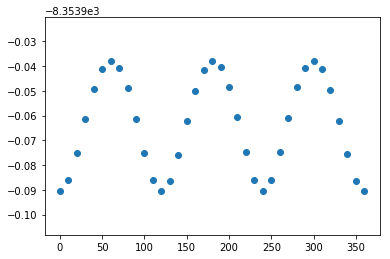

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor03_a2.log
DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor03_a3.log
DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor03_a4.log


Found:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor04_a1.log
[CH2]CC(=O)OC
<Torsion "(3, 0, 4, 2)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 36
CANNOT Load Scan



DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor04_a2.log
DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor04_a3.log
DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor04_a4.log


Found:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor24_a1.log
[CH2]CC(=O)OC
<Torsion "(5, 2, 4, 1)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


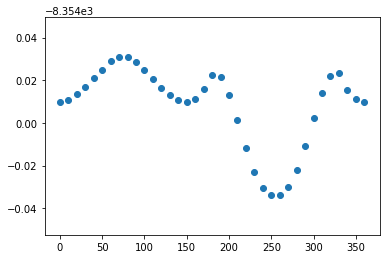

Continuous:   True

Good Slope:   True

Lowest Conf:  False


DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor24_a2.log
DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor24_a3.log
DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor24_a4.log


Found:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor25_a1.log
[CH2]CC(=O)OC
<Torsion "(4, 2, 5, 12)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


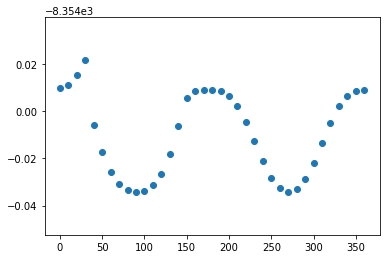

Continuous:   True

Good Slope:   False

Lowest Conf:  False


DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor25_a2.log
DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor25_a3.log
DNFind:  NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor25_a4.log




In [39]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[16]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['[CH2]OC(=O)CC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run1/[CH2]OC(=O)CC/From_Workflow


Found:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor05_a1.log
[CH2]OC(=O)CC
<Torsion "(4, 0, 5, 11)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


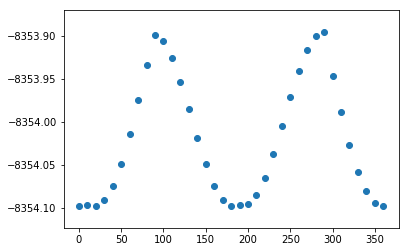

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor05_a2.log
DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor05_a3.log
DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor05_a4.log


Found:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor04_a1.log
[CH2]OC(=O)CC
<Torsion "(5, 0, 4, 2)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


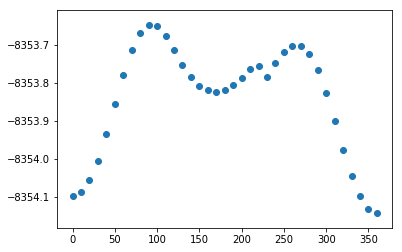

Continuous:   False

Good Slope:   True

Lowest Conf:  False


DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor04_a2.log
DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor04_a3.log
DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor04_a4.log


Found:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor23_a1.log
[CH2]OC(=O)CC
<Torsion "(7, 2, 3, 8)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


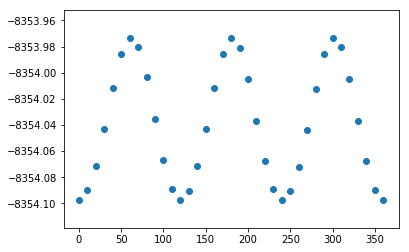

Continuous:   True

Good Slope:   True

Lowest Conf:  True


DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor23_a2.log
DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor23_a3.log
DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor23_a4.log


Found:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor24_a1.log
[CH2]OC(=O)CC
<Torsion "(7, 2, 4, 1)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37


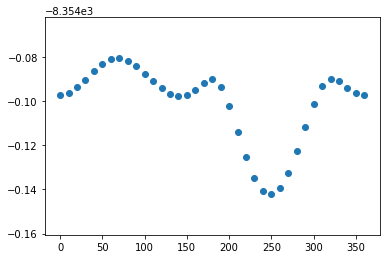

Continuous:   True

Good Slope:   True

Lowest Conf:  False


DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor24_a2.log
DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor24_a3.log
DNFind:  OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor24_a4.log




In [40]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[17]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

In [41]:
steps = 72
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[18]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run1' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

IndexError: list index out of range